<a href="https://colab.research.google.com/github/nahumsa/DM-Reconstruction/blob/master/Reconstruct%20DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconstruction of a density matrix

### Import dependencies for Google Colab

In [1]:
from IPython.display import clear_output
! git clone https://github.com/nahumsa/DM-Reconstruction
clear_output()

In [2]:
!pip install qutip
clear_output()

In [3]:
% cd DM-Reconstruction/
clear_output()

##Import Dependencies

In [4]:
try:
  %tensorflow_version 2.x

except Exception:
  pass
  
import tensorflow as tf

#Set Random Seed for reproduction
tf.random.set_seed(1234)

# Remove warnings
import logging
logging.getLogger('tensorflow').disabled = True

#Use this to not need to initialize tensors outside session
tf.config.experimental_run_functions_eagerly(True)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import qutip
from tqdm.notebook import tqdm

## Creating dataset

In [7]:
X_train = np.loadtxt('Data/Measurements/X_train.txt')
X_test = np.loadtxt('Data/Measurements/X_test.txt')

# Models

## Using Trace distance as a loss function

In [8]:
from Models.TVAE import TraceVAE

ZDIM = 20
input_dim = X_train.shape[1]
hidden_dims = [64,128,256]
batchsize = 32
dropout_rate=0.3

vae = TraceVAE(original_dim=input_dim,
               intermediate_dim=hidden_dims,
               latent_dim=ZDIM,
               dropout_rate=dropout_rate)

# Optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer=optimizer)

# Prepare a dataset.
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
val_dataset = tf.data.Dataset.from_tensor_slices(X_test)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batchsize)

In [9]:
from Utils.Plotter import PeriodicPlotter

r_loss = 10.
beta = 1e-2
epochs = 10

# Periodic Plotter for loss
plotter = PeriodicPlotter(sec=5, xlabel='Epochs', ylabel='Loss')

loss_epochs, val_loss_epochs, fidelity_epochs, val_fidelity_epochs = vae.training(dataset, 
                                                                                  epochs, 
                                                                                  r_loss, 
                                                                                  beta,
                                                                                  test=val_dataset, 
                                                                                  )#Plotter=plotter)

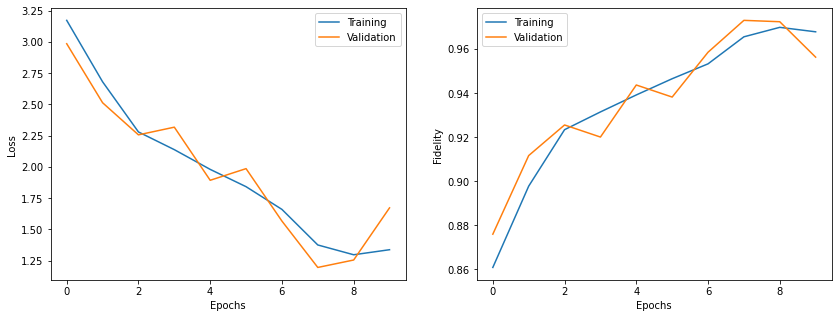

In [10]:
epochs = range(len(loss_epochs))

fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs,loss_epochs, label='Training')
ax1.plot(epochs,val_loss_epochs, label='Validation')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,fidelity_epochs, label='Training')
ax2.plot(epochs,val_fidelity_epochs, label='Validation')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Fidelity')
ax2.legend()
plt.show()

In [ ]:
import os
# Saving results
save = True
if save:
  np.savetxt('Results/TVAE/TVAE_Fidelity.txt', fidelity_epochs)
  np.savetxt('Results/TVAE/TVAE_Loss.txt', loss_epochs)
  np.savetxt('Results/TVAE/val_TVAE_Fidelity.txt', val_fidelity_epochs)
  np.savetxt('Results/TVAE/val_TVAE_Loss.txt', val_loss_epochs)

# Denoising measurements with gaussian error

In [ ]:
from Utils.Dataset import create_x
n_measurements = len(measurements_train[0])
noise_factor = 0.1

#Transforming in an np.array
X_train = np.array(create_x(measurements_train)) + noise_factor*np.random.randn(samples_train,n_measurements)
Y_train = np.array(create_x(measurements_train))
labels_train = np.array(labels_train)

X_test = np.array(create_x(measurements_test)) + noise_factor*np.random.randn(samples_test,n_measurements)
Y_test = np.array(create_x(measurements_test))
labels_test = np.array(labels_test)

print(f"Shape of the Training: \n X: {X_train.shape} \n Y: {Y_train.shape}")
print(f"Shape of the Training: \n X: {X_test.shape} \n Y: {Y_test.shape}")

Shape of the Training: 
 X: (5000, 15) 
 Y: (5000, 15)
Shape of the Training: 
 X: (3000, 15) 
 Y: (3000, 15)


In [ ]:
from Models.TVAE import TraceVAE
from Utils.QMetrics import trace_loss, fidelity_rho

class Denoise(TraceVAE):
  def __init__(self,
               original_dim,
               intermediate_dim,
               latent_dim,               
               dropout_rate,
               **kwargs):    

    super(Denoise, self).__init__(original_dim,
                                   intermediate_dim,
                                   latent_dim,
                                   dropout_rate)
      
  def training_step(self, x, y, r_loss, beta):
    """Training step for the VAE.
  
    Parameters
    -------------------------------------------
    x: Data with noise
    y: Data without noise
    VAE(tf.keras.Model): Variational Autoencoder model. 
    optimizer(tf.keras.optimizer): Optimizer used.  
    r_loss(float): Parameter controlling reconstruction loss.
    beta(float): Parameter controlling the KL divergence.

    Return:
    Loss(float): Loss value of the training step.

    """
    with tf.GradientTape() as tape:
      reconstructed = self(x)  # Compute input reconstruction.
      # Compute loss.      
      loss = trace_loss(y, reconstructed)
      kl = sum(self.losses)
      loss = r_loss * loss + beta*kl  
    
    # Update the weights of the VAE.
    grads = tape.gradient(loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))    
    
    fid = []
    for val_1, val_2 in zip(y.numpy(), reconstructed.numpy()):
      fid.append(fidelity_rho(val_1,val_2))    

    return loss, np.mean(fid)

  def validating_step(self, x, y, r_loss, beta):
    """Validation step for the VAE.
  
    Parameters
    -------------------------------------------
    x: Data    
    r_loss(float): Parameter controlling reconstruction loss.
    beta(float): Parameter controlling the KL divergence.

    Return:
    Loss(float): Loss value of the training step.

    """

    reconstructed = self(x)  # Compute input reconstruction.
    # Compute loss.      
    loss = trace_loss(y, reconstructed)
    kl = sum(self.losses)
    loss = r_loss * loss + beta*kl

    fid = []
    for val_1, val_2 in zip(y.numpy(), reconstructed.numpy()):
      fid.append(fidelity_rho(val_1,val_2))  

    return loss, np.mean(fid)

  def training(self, dataset,
             epochs, r_loss, beta,              
             test=None, Plotter=None):
    """ Training of the Variational Autoencoder for a 
    tensorflow.dataset.

    Parameters
    -------------------------------------------
    dataset(tf.data.Dataset): Dataset of the data.
    VAE(tf.keras.Model): Variational Autoencoder model.
    epochs(int): Number of epochs.
    r_loss(float): Parameter controlling reconstruction loss.
    beta(float): Parameter controlling the KL divergence.  
    Plotter(object): Plotter object to show how the training is
                    going (Default=None).

    """

    losses = []
    val_losses = []   
    fidelities = []
    val_fidelities = [] 
    epochs = range(epochs)

    for i in tqdm(epochs, desc='Epochs'):
      losses_epochs = []
      fidelity_epochs =[]
      for step, (x, y) in enumerate(dataset):

        loss, fidelity = self.training_step(x, y, r_loss, beta)
  
        # Logging.
        losses_epochs.append(float(loss))
        fidelity_epochs.append(float(fidelity))
      
      losses.append(np.mean(losses_epochs))
      fidelities.append(np.mean(fidelity_epochs))

      if test:
        val_losses_epochs = []
        val_fidelity_epochs = []

        for step, (x, y) in enumerate(test):
          val_loss, val_fidelity = self.validating_step(x, y, r_loss, beta)
    
          # Logging.
          val_losses_epochs.append(float(val_loss))
          val_fidelity_epochs.append(float(val_fidelity))
        
        val_losses.append(np.mean(val_losses_epochs))  
        val_fidelities.append(np.mean(val_fidelity_epochs))
      
      if Plotter != None:
        if test:
          Plotter.plot([losses,val_losses])
        else:
          Plotter.plot(losses)
        

    return losses, val_losses, fidelities, val_fidelities

In [ ]:
ZDIM = 20
input_dim = X_train.shape[1]
hidden_dims = [64,128,256]
batchsize = 32
dropout_rate=0.3

denoise = Denoise(original_dim=input_dim,
                   intermediate_dim=hidden_dims,
                   latent_dim=ZDIM,
                   dropout_rate=dropout_rate)

# Optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

denoise.compile(optimizer=optimizer)

In [ ]:
# Prepare a dataset.
dataset = tf.data.Dataset.from_tensor_slices((X_train,Y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test,Y_test))
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batchsize)

In [ ]:
from Utils.Plotter import PeriodicPlotter

r_loss = 10.
beta = 1e-2
epochs = 20

# Periodic Plotter for loss
plotter = PeriodicPlotter(sec=5, xlabel='Epochs', ylabel='Loss')

loss_epochs, val_loss_epochs, fidelity_epochs, val_fidelity_epochs = denoise.training(dataset, 
                                                                                      epochs, 
                                                                                      r_loss, 
                                                                                      beta,                                                                                       
                                                                                      test=val_dataset,
                                                                                      )#Plotter=plotter )

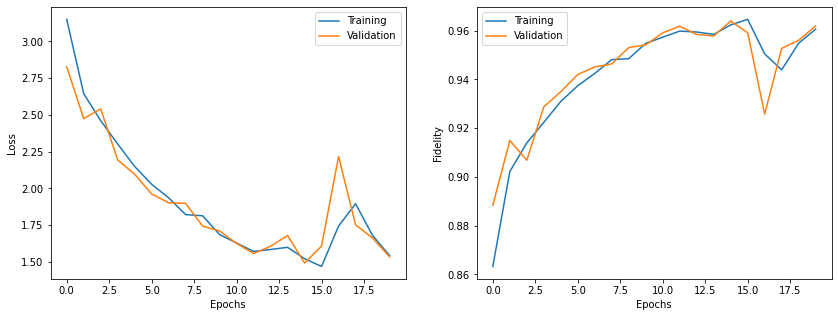

In [ ]:
epochs = range(len(loss_epochs))

fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs,loss_epochs, label='Training')
ax1.plot(epochs,val_loss_epochs, label='Validation')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,fidelity_epochs, label='Training')
ax2.plot(epochs,val_fidelity_epochs, label='Validation')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Fidelity')
ax2.legend()
plt.show()

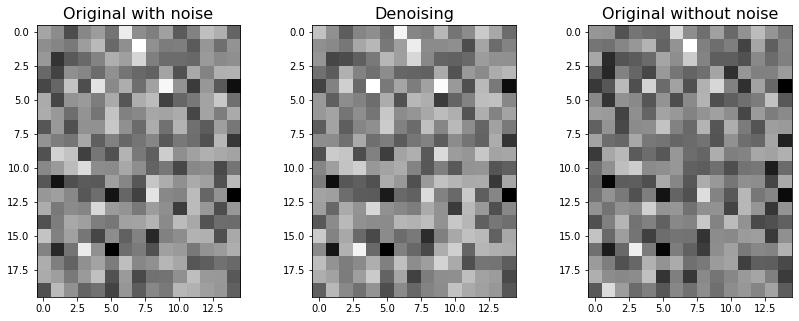

In [ ]:
fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

ax1.imshow((X_test[0:20]), cmap="gray")
ax1.set_title('Original with noise', size=16)

ax2.imshow(denoise.predict(X_test[0:20]), cmap="gray")
ax2.set_title('Denoising', size=16)

ax3.imshow((Y_test[0:20]), cmap="gray")
ax3.set_title('Original without noise', size=16)
plt.show()

# Trace distance with separable states

In [ ]:
from Utils.Dataset import create_dataset

samples_train = 5000
states_train, measurements_train, labels_train = create_dataset(samples_train)

samples_test = 3000
states_test, measurements_test, labels_test = create_dataset(samples_test)

In [ ]:
from Utils.Dataset import create_x

#Transforming in an np.array
X_train = np.array(create_x(measurements_train))
Y_train = np.array(labels_train)

X_test = np.array(create_x(measurements_test))
Y_test = np.array(labels_test)

# Prepare a dataset.
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)

In [ ]:
from Models.TVAE import TraceVAE
from Utils.QMetrics import trace_loss, create_2qubit_density_mat
from Utils.Dataset import generate_separable

class Entanglement(TraceVAE):
  def __init__(self,
               original_dim,
               intermediate_dim,
               latent_dim,               
               **kwargs):    

    super(Entanglement, self).__init__(original_dim,
                                   intermediate_dim,
                                   latent_dim)
    
  def training_step(self, x, r_loss, beta):
    """Training step for the VAE.
  
    Parameters
    -------------------------------------------
    x: Data.
    VAE(tf.keras.Model): Variational Autoencoder model. 
    optimizer(tf.keras.optimizer): Optimizer used.  
    r_loss(float): Parameter controlling reconstruction loss.
    beta(float): Parameter controlling the KL divergence.

    Return:
    Loss(float): Loss value of the training step.

    """
    with tf.GradientTape() as tape:
      reconstructed = self(x)  # Compute input reconstruction.
      # Compute loss.

      sep_states, sep_measurements = generate_separable(len(x))
      sep_measurements = tf.Variable(create_x(sep_measurements), dtype=tf.dtypes.complex64)      
      loss = trace_loss(sep_measurements, reconstructed)
      kl = sum(self.losses)
      loss = r_loss * loss + beta*kl  
    
    # Update the weights of the VAE.
    grads = tape.gradient(loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))    
    
    return loss


In [ ]:
ZDIM = 2
input_dim = X_train.shape[1]
hidden_dims = [64,128,256]
batchsize = 512

ent = Entanglement(original_dim=input_dim,
               intermediate_dim=hidden_dims,
               latent_dim=ZDIM)

# Optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

ent.compile(optimizer=optimizer)

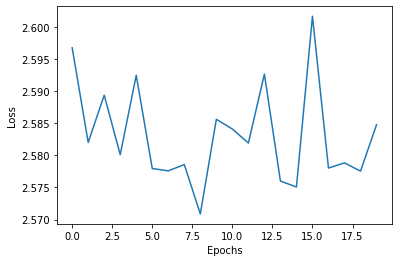

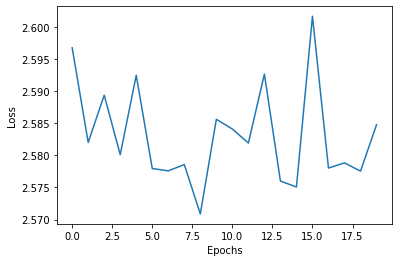

In [ ]:
from Utils.Plotter import PeriodicPlotter

r_loss = 10.
beta = 1e-5
epochs = 20

# Periodic Plotter for loss
plotter = PeriodicPlotter(sec=5, xlabel='Epochs', ylabel='Loss')

loss_epochs = ent.training(dataset, epochs, r_loss, beta, Plotter=plotter)

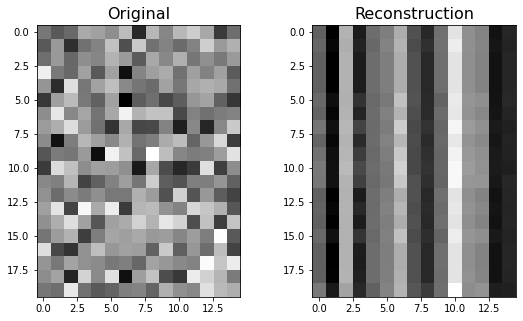

In [ ]:
fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


ax1.imshow((X_train[0:20]), cmap="gray")
ax1.set_title('Original', size=16)

ax2.imshow(ent.predict(X_train[0:20]), cmap="gray")
ax2.set_title('Reconstruction', size=16)

#_, _, z = ent.encoder(X_test)
#z = z.numpy()

#ax3 = fig.add_subplot(gs[0, 2])
#ims = ax3.scatter(z[:,0], z[:,1], c=Y_test)
#ax3.set_title('Latent Space', size=16)
#plt.colorbar(ims, ax=ax3)

plt.show()

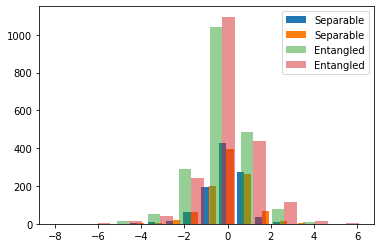

In [ ]:
mask = Y_test == 1
X_c = X_test[mask]
Y_c = Y_test[mask]

zz_mean,zz_log_var,zz=vae.encoder(X_c)
zz=zz.numpy()


mask = Y_test == -1
X_cc = X_test[mask]
Y_cc = Y_test[mask]

zzc_mean,zzc_log_var,zzc=vae.encoder(X_cc)
zzc=zzc.numpy()

#print(zzc.shape)
plt.hist(zzc, label=['Separable','Separable'])
plt.hist(zz, alpha=0.5, label=['Entangled','Entangled'])
plt.legend()
plt.show()

### Evaluating entangled and separable states


Separable

In [ ]:
from Utils.Dataset import generate_separable
n_meas = 1000
state, meas = generate_separable(n_meas)
meas = np.array(create_x(meas))
print(f'Trace loss: {trace_loss(ent(meas),meas)}')

Trace loss: 0.25881725549697876



Entangled

In [ ]:
from Utils.Dataset import generate_entangled
n_meas = 1000
state, meas = generate_entangled(n_meas)
meas = np.array(create_x(meas))
print(f'Trace loss: {trace_loss(ent(meas),meas)}')

Trace loss: 0.3399774134159088


# Adding a sample of separable states into training

In [ ]:
from Utils.Dataset import create_dataset
from Utils.Dataset import create_x

samples_train = 5000
states_train, measurements_train, labels_train = create_dataset(samples_train)

samples_test = 3000
states_test, measurements_test, labels_test = create_dataset(samples_test)

#Transforming in an np.array
X_train = np.array(create_x(measurements_train))
Y_train = np.array(labels_train)

X_test = np.array(create_x(measurements_test))
Y_test = np.array(labels_test)

# Prepare a dataset.
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)

In [ ]:
#Adding n_meas separable states to the train data
n_meas = 1000
state, meas = generate_separable(n_meas)
meas = create_x(meas)
X_train_aug = np.append(X_train, meas, axis=0)

In [ ]:
from Models.TVAE import TraceVAE

ZDIM = 2
input_dim = X_train.shape[1]
hidden_dims = [64,128,256]
batchsize = 32

vae = TraceVAE(original_dim=input_dim,
               intermediate_dim=hidden_dims,
               latent_dim=ZDIM)

# Optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer=optimizer)

# Prepare a dataset.
dataset = tf.data.Dataset.from_tensor_slices(X_train_aug)
dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)

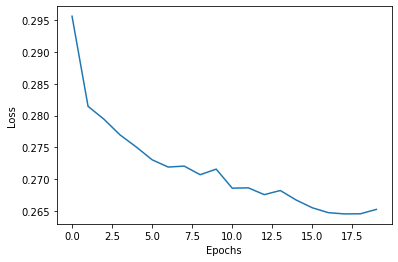

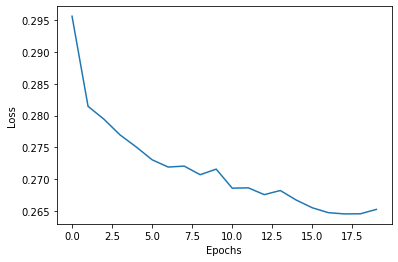

In [ ]:
from Utils.Plotter import PeriodicPlotter

r_loss = 1.
beta = 1e-4
epochs = 20

# Periodic Plotter for loss
plotter = PeriodicPlotter(sec=5, xlabel='Epochs', ylabel='Loss')

loss_epochs = vae.training(dataset, epochs, r_loss, beta, Plotter=plotter)

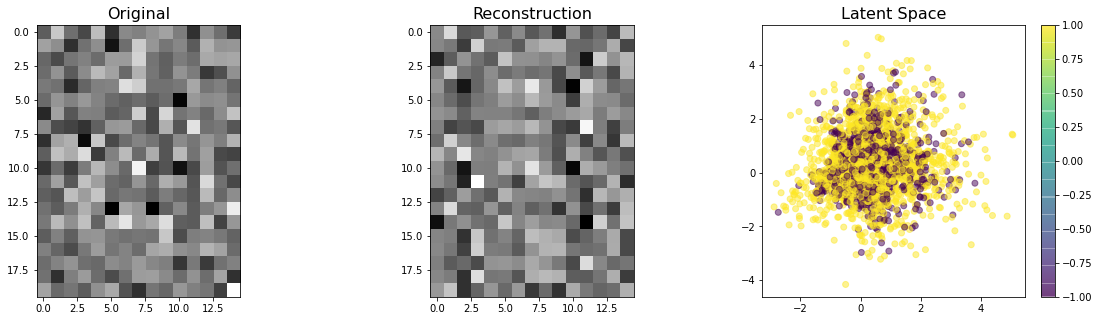

In [ ]:
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


ax1.imshow((X_test[0:20]), cmap="gray")
ax1.set_title('Original', size=16)

ax2.imshow(vae.predict(X_test[0:20]), cmap="gray")
ax2.set_title('Reconstruction', size=16)

_, _, z = vae.encoder(X_test)
z = z.numpy()

ax3 = fig.add_subplot(gs[0, 2])
ims = ax3.scatter(z[:,0], z[:,1], alpha=0.5, c=Y_test)
ax3.set_title('Latent Space', size=16)
plt.colorbar(ims, ax=ax3)

plt.show()

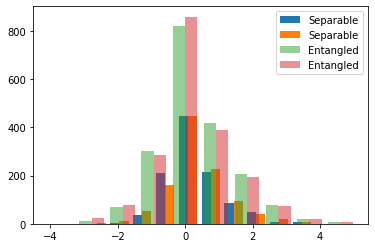

In [ ]:
mask = Y_test == 1
X_c = X_test[mask]
Y_c = Y_test[mask]

zz_mean,zz_log_var,zz=vae.encoder(X_c)
zz=zz.numpy()


mask = Y_test == -1
X_cc = X_test[mask]
Y_cc = Y_test[mask]

zzc_mean,zzc_log_var,zzc=vae.encoder(X_cc)
zzc=zzc.numpy()

#print(zzc.shape)
plt.hist(zzc, label=['Separable','Separable'])
plt.hist(zz, alpha=0.5, label=['Entangled','Entangled'])
plt.legend()
plt.show()